# Changes from Model v2.1

We improved from 2.0 to 2.1 some digits
To make sure the model is not overfitting, we are going to change some parameters:

* number of estimators from 1000 to 2000
* learning rate from 0.05 to 0.03
* increasing the reg_lambda from 10 to 15
* increasing the reg_alpha from 1 to 2

Updating the parameters for XKB v2.0 from:

``` python
xgb_base_model = XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    min_child_weight=6,
    colsample_bytree=0.8,
    subsample=0.8,
    gamma=1,
    reg_lambda=10.0,
    reg_alpha=1.0,
    objective='reg:squarederror',
    random_state=42,
)
```

to

``` python
xgb_base_model = XGBRegressor(
    n_estimators=2000,
    max_depth=6,
    learning_rate=0.03,
    min_child_weight=6,
    colsample_bytree=0.8,
    subsample=0.8,
    gamma=1,
    reg_lambda=15.0,
    reg_alpha=2.0,
    objective='reg:squarederror',
    random_state=42,
)
```

**Result Score: xxx**

Conclusion:

* The RMSEs of out train/test splits are great and seem to be improving a lot the predictions.
* This is not the case. I think we have here a overfitting problem.  

# Create a baseline model

In [1]:
import pandas as pd

from data import load_data_selected_features

train_data, additional_train_data, test_data = load_data_selected_features()

In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150996 entries, p01_0 to p12_25298
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 585.2+ MB


In [3]:
additional_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168588 entries, p01_test_12 to p24_test_94938
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 657.4+ MB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3644 entries, p01_8459 to p24_260
Columns: 506 entries, p_num to activity-0:00
dtypes: float64(432), object(74)
memory usage: 14.2+ MB


# Prepare the data

In [5]:
from pipelines_selected_features import pipeline

all_train_data = pd.concat([train_data, additional_train_data], axis=0)
all_train_data_transformed = pipeline.fit_transform(all_train_data)

train_data_transformed = all_train_data_transformed[:len(train_data)]
additional_train_data_transformed = all_train_data_transformed[len(train_data):]

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

X_additional_train = additional_train_data_transformed.drop(columns=['bg+1:00'])
y_additional_train = additional_train_data_transformed['bg+1:00']

## Create the model

In [6]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LassoLarsIC, Ridge

hgb_estimator = HistGradientBoostingRegressor(
    l2_regularization=0.0001,
    learning_rate=0.1,
    max_depth=11,
    max_iter=1500,
    min_samples_leaf=10,
    n_iter_no_change=22,
    random_state=42,
)

lasso_lars_ic_base_model = LassoLarsIC(
    criterion='aic',
    eps=0.03922948513965659,
    max_iter=1944,
    noise_variance=5.4116687755186035e-05,
    positive=False,
)
knn_base_model = KNeighborsRegressor(n_neighbors=5)

xgb_base_model = XGBRegressor(
    n_estimators=2000,
    max_depth=6,
    learning_rate=0.03,
    min_child_weight=6,
    colsample_bytree=0.8,
    subsample=0.8,
    gamma=1,
    reg_lambda=15.0,
    reg_alpha=2.0,
    objective='reg:squarederror',
    random_state=42,
)

estimators = [
    ('hgb', hgb_estimator),
    ('lasso_lars_ic', lasso_lars_ic_base_model),
    ('knn', knn_base_model),
    ('xgb', xgb_base_model),
]

model = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=0.1), n_jobs=-1, verbose=2)

21:09:26 - 21:09:26 - Start training
21:09:26 - 21:09:26 - Calculate performance for hgb
21:09:26 - 21:09:26 - Splitting the additional train data with ShuffleSplit
21:09:26 - 21:09:26 - Split 1 - Model: hgb
21:09:26 - 21:09:26 - Fitting the model
21:17:39 - 21:17:39 - Predicting
21:17:42 - 21:17:42 - Calculating scores
21:17:45 - 21:17:45 - R^2: 0.6802980598686639, RMSE: 1.853234323545247, MAE: 1.3781103796392653, MSE: 3.4344774579662096
21:17:45 - 21:17:45 - Split 2 - Model: hgb
21:17:45 - 21:17:45 - Fitting the model
21:23:41 - 21:23:41 - Predicting
21:23:42 - 21:23:42 - Calculating scores
21:23:43 - 21:23:43 - R^2: 0.6790084797635141, RMSE: 1.8599546082369873, MAE: 1.389380261014941, MSE: 3.4594311447020054
21:23:43 - 21:23:43 - Split 3 - Model: hgb
21:23:43 - 21:23:43 - Fitting the model
21:26:33 - 21:26:33 - Predicting
21:26:35 - 21:26:35 - Calculating scores
21:26:36 - 21:26:36 - R^2: 0.6768352388557501, RMSE: 1.8473604416799103, MAE: 1.3794091734729261, MSE: 3.4127406014837933


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.8s remaining:    8.7s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.5min remaining:  6.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.5min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.4min remaining:  8.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.4min finished


21:49:05 - 21:49:05 - Predicting
21:49:19 - 21:49:19 - Calculating scores
21:49:33 - 21:49:33 - R^2: 0.6868996364635718, RMSE: 1.8340006495505892, MAE: 1.3493378270541276, MSE: 3.363558382551983
21:49:33 - 21:49:33 - Split 2 - Model: stacking_regressor
21:49:34 - 21:49:34 - Fitting the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.8min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.7min remaining:  7.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.7min finished


21:56:27 - 21:56:27 - Predicting
21:56:43 - 21:56:43 - Calculating scores
21:56:59 - 21:56:59 - R^2: 0.6834309333879641, RMSE: 1.847097427868576, MAE: 1.3642071054211187, MSE: 3.4117689080387086
21:56:59 - 21:56:59 - Split 3 - Model: stacking_regressor
21:56:59 - 21:56:59 - Fitting the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.0s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.8min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.8min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.8min finished


22:04:21 - 22:04:21 - Predicting
22:04:36 - 22:04:36 - Calculating scores
22:04:50 - 22:04:50 - R^2: 0.6844487606978931, RMSE: 1.8254695195120774, MAE: 1.3464168462824753, MSE: 3.332338966667655
22:04:50 - 22:04:50 - Split 4 - Model: stacking_regressor
22:04:51 - 22:04:51 - Fitting the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.1min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.2min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.1min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.1min finished


22:12:10 - 22:12:10 - Predicting
22:12:25 - 22:12:25 - Calculating scores
22:12:41 - 22:12:41 - R^2: 0.684338569567208, RMSE: 1.8470822807666165, MAE: 1.3643393625902775, MSE: 3.4117129519220057
22:12:41 - 22:12:41 - Split 5 - Model: stacking_regressor
22:12:41 - 22:12:41 - Fitting the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.0s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.7min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.7min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.6min remaining:  6.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min finished


22:20:12 - 22:20:12 - Predicting
22:20:26 - 22:20:26 - Calculating scores
22:20:40 - 22:20:40 - R^2: 0.6789302786033469, RMSE: 1.8392494368605616, MAE: 1.356872929553226, MSE: 3.3828384909918934
22:20:40 - 22:20:40 - Training finished


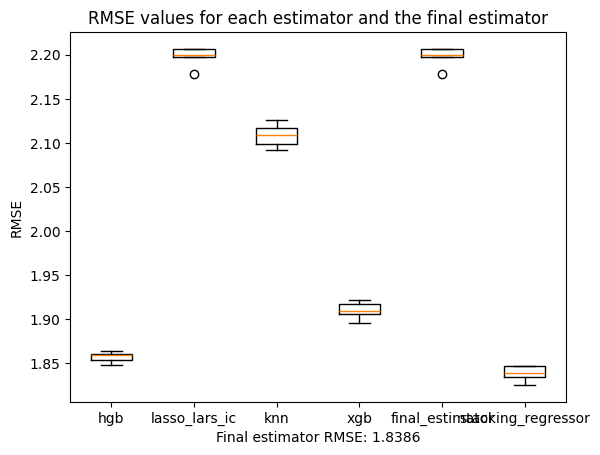

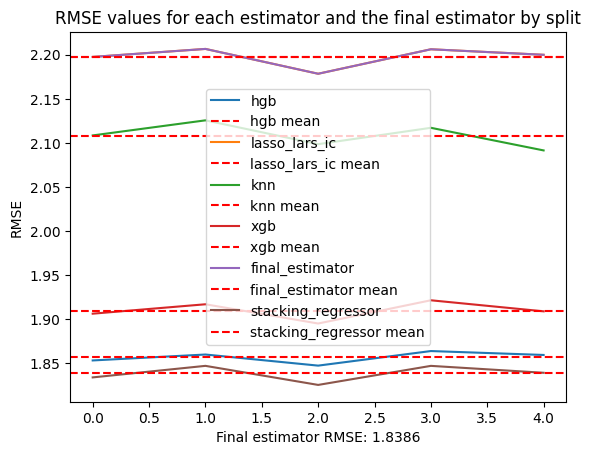

In [7]:
from datetime import datetime
import os
from model_performance_calculations import calculate_stacking_regressor_performance, get_rmse_boxplot_chart, get_rmse_line_chart, save_performances, save_model

date_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_name = f'{date_time}-model-v2.2'

save_model(model, os.path.join('models', f'{model_name}.pkl'))

performances = calculate_stacking_regressor_performance(model, X_train, y_train, X_additional_train, y_additional_train, n_splits=5)
save_performances(performances, os.path.join('models', f'{model_name}-performances.json'))

get_rmse_boxplot_chart(performances).show()
get_rmse_line_chart(performances).show()

## Predict test data

In [8]:
import numpy as np
from pipelines_selected_features import pipeline

all_train_data_transformed = pipeline.fit_transform(pd.concat([train_data, additional_train_data], axis=0))
X_train = all_train_data_transformed.drop(columns=['bg+1:00'])
y_train = all_train_data_transformed['bg+1:00']

model.fit(X_train, y_train)
X_test = pipeline.transform(test_data)
y_pred = model.predict(X_test)

if np.sum(y_pred < 0) > 0:
    print(f'Number of negative values: {np.sum(y_pred < 0)}')
    bg_min_train = np.min(y_train)
    print(f'Min value: {np.min(y_pred)}')
    print(f'Filling negative values with {bg_min_train}')
    y_pred = np.where(y_pred < 0, bg_min_train, y_pred)

test_data['bg+1:00'] = y_pred
test_data.head()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.6s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.9min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.8min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.9min finished


,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,p01,06:45:00,NaN,9.2,NaN,NaN,10.2,NaN,NaN,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.887423
p01_8460,p01,11:25:00,NaN,NaN,9.9,NaN,NaN,9.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Walk,Walk,Walk,5.985492
p01_8461,p01,14:45:00,NaN,5.5,NaN,NaN,5.5,NaN,NaN,5.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.992326
p01_8462,p01,04:30:00,NaN,3.4,NaN,NaN,3.9,NaN,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.072821
p01_8463,p01,04:20:00,NaN,NaN,8.3,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.723567


In [9]:
submission = pd.DataFrame(test_data['bg+1:00'])
submission

,bg+1:00
id,
p01_8459,8.887423
p01_8460,5.985492
p01_8461,7.992326
p01_8462,11.072821
p01_8463,6.723567
...,...
p24_256,6.111383
p24_257,10.284168
p24_258,6.421919


In [10]:
submission.to_csv(f'submission-{model_name}.csv')